In [1]:
import os
import h5py
import numpy as np 
from sklearn.decomposition import NMF
from astropy.convolution import Gaussian1DKernel, convolve, Box1DKernel

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# Read in TNG SFHs

In [3]:
f_sfh = os.path.join(os.environ['HOME'], 'data', 'gqp_mc', 'tng', 'IQ_TNG_SFRHs-corrected.hdf5')
fsfh = h5py.File(f_sfh, 'r')

sfhs = fsfh['SFRH'][...] # stellar mass formed in bins of time and metallicity

In [4]:
# we don't care much about metallicity bins so lets add them up.
# also the last min in SFH doesn't make sense
sfhs_t = np.sum(sfhs, axis=2)[:,:-1] # SFH(t)

In [5]:
# read in corresponding bin edges
_t_low, _t_high = np.loadtxt(os.path.join(os.environ['HOME'], 'data', 'gqp_mc', 'tng', 't_sfh.txt'), delimiter=',', unpack=True, usecols=[0,1])
t_low = _t_low[:-1]
t_high = _t_high[:-1]
t_mid = 0.5 * (t_low + t_high)
dt = t_high - t_low

In [6]:
dt

array([0.005, 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.03 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 , 0.05 ,
       0.075, 0.1  , 0.1  , 0.1  , 0.1  , 0.175, 0.25 , 0.25 , 0.25 ,
       0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.375,
       0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  ,
       0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.5  ,
       0.5  ])

Recent SFHs are binned way too finely. Lets rebin in cosmic time

In [7]:
def rebin(edges0, sfh0, edges1): 
    '''given edges and SFH rebin to edges1
    '''
    sfh0 = np.atleast_2d(sfh0)
    
    nbin = len(edges1) - 1
    sfh1 = np.empty((sfh0.shape[0], nbin))
    for i in range(nbin): 
        xp0, xp1 = edges1[i], edges1[i+1]
        
        # add up old bins that entirely fall inside
        i0 = np.where(edges0 >= xp0)[0][0]
        i1 = np.where(edges0 < xp1)[0][-1]
        
        sfh1[:,i] = np.sum(sfh0[:,i0:i1], axis=1)
        # add partial contributiones 
        if edges0[i0] > xp0: 
            sfh1[:,i] += sfh0[:,i0-1] * (edges0[i0] - xp0)/(edges0[i0] - edges0[i0-1])
        
        if edges0[i1] < xp1:
            sfh1[:,i] += sfh0[:,i1] * (xp1 - edges0[i1])/(edges0[i1+1] - edges0[i1])
    return sfh1

In [8]:
t_low_coarse = 0.25 * np.arange(55)
t_high_coarse = t_low_coarse + 0.25
t_mid_coarse = 0.5 * (t_low_coarse + t_high_coarse)
dt_coarse = t_high_coarse - t_low_coarse

In [9]:
sfhs_t_coarse = rebin(np.concatenate([t_low, [t_high[-1]]]), sfhs_t, 0.25*np.arange(56))

In [11]:
print((np.sum(sfhs_t, axis=1) - np.sum(sfhs_t_coarse, axis=1)).max())

7.105427357601002e-15


In [12]:
sfrhs_t = sfhs_t_coarse / dt_coarse # divide by bin width to get SFR
Msum = np.trapz(sfrhs_t, t_mid_coarse) # noramlization 

normed_sfrhs_t = sfrhs_t / Msum[:,None]

Lets smooth out the SFHs to remove any binning artifacts

In [13]:
def smooth_SFH(y, smooth_std):
    g = Box1DKernel(smooth_std, mode='center')
    y_smooth = convolve(y, g, boundary='extend')
    return y_smooth

In [14]:
smooth_normed_sfrhs_t = np.array([smooth_SFH(normed_sfrhs_t[i,:], 10) for i in range(normed_sfrhs_t.shape[0])])

(0.0, 1.0)

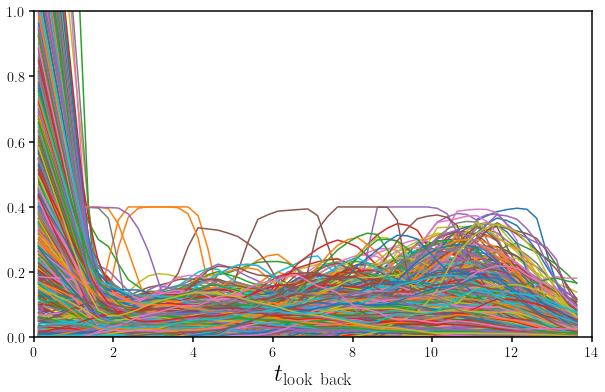

In [15]:
fig = plt.figure(figsize=(10, 6))
sub = fig.add_subplot(111)
for i in np.random.choice(np.arange(sfhs.shape[0]), size=1000): 
    sub.plot(t_mid_coarse, smooth_normed_sfrhs_t[i])
sub.set_xlabel(r'$t_{\rm look~back}$', fontsize=25)
sub.set_xlim(0., 14)
sub.set_ylim(0., 1)

In [17]:
n_comp = 6

(0.0, 1.3724750355144577)

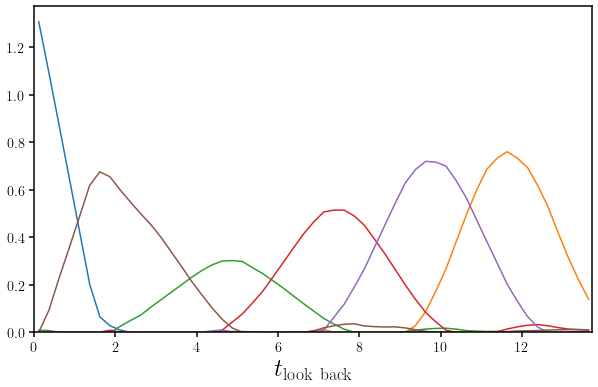

In [18]:
model = NMF(n_components=n_comp, init='random', random_state=0)
W = model.fit_transform(smooth_normed_sfrhs_t[Msum > 1e1])
H = model.components_

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
for _H in H: 
    sub.plot(t_mid_coarse, _H)
sub.set_xlabel(r'$t_{\rm look~back}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_ylim(0, None)

Lets save the components

In [21]:
np.savetxt('t_sfh.tng%icomp.txt' % n_comp, t_low_coarse)

In [22]:
np.savetxt('NMF_basis.sfh.tng%icomp.txt' % n_comp, H.T)